# Mask-RCNN inference tests

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

In [2]:
pylab.rcParams['figure.figsize'] = 20, 12

In [8]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util


class COCODemo(object):
    # COCO categories for pretty print
    CATEGORIES = [
        "__background",
        "person",
        "bicycle",
        "car",
        "motorcycle",
        "airplane",
        "bus",
        "train",
        "truck",
        "boat",
        "traffic light",
        "fire hydrant",
        "stop sign",
        "parking meter",
        "bench",
        "bird",
        "cat",
        "dog",
        "horse",
        "sheep",
        "cow",
        "elephant",
        "bear",
        "zebra",
        "giraffe",
        "backpack",
        "umbrella",
        "handbag",
        "tie",
        "suitcase",
        "frisbee",
        "skis",
        "snowboard",
        "sports ball",
        "kite",
        "baseball bat",
        "baseball glove",
        "skateboard",
        "surfboard",
        "tennis racket",
        "bottle",
        "wine glass",
        "cup",
        "fork",
        "knife",
        "spoon",
        "bowl",
        "banana",
        "apple",
        "sandwich",
        "orange",
        "broccoli",
        "carrot",
        "hot dog",
        "pizza",
        "donut",
        "cake",
        "chair",
        "couch",
        "potted plant",
        "bed",
        "dining table",
        "toilet",
        "tv",
        "laptop",
        "mouse",
        "remote",
        "keyboard",
        "cell phone",
        "microwave",
        "oven",
        "toaster",
        "sink",
        "refrigerator",
        "book",
        "clock",
        "vase",
        "scissors",
        "teddy bear",
        "hair drier",
        "toothbrush",
    ]

    def __init__(
        self,
        cfg,
        confidence_threshold=0.7,
        show_mask_heatmaps=False,
        masks_per_dim=2,
        min_image_size=224,
    ):
        self.cfg = cfg.clone()
        self.model = build_detection_model(cfg)
        self.model.eval()
        self.device = torch.device(cfg.MODEL.DEVICE)
        self.model.to(self.device)
        self.min_image_size = min_image_size

        save_dir = cfg.OUTPUT_DIR
        checkpointer = DetectronCheckpointer(cfg, self.model, save_dir=save_dir)
        _ = checkpointer.load(cfg.MODEL.WEIGHT)

        self.transforms = self.build_transform()

        mask_threshold = -1 if show_mask_heatmaps else 0.5
        self.masker = Masker(threshold=mask_threshold, padding=1)

        # used to make colors for each class
        self.palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])

        self.cpu_device = torch.device("cpu")
        self.confidence_threshold = confidence_threshold
        self.show_mask_heatmaps = show_mask_heatmaps
        self.masks_per_dim = masks_per_dim

    def build_transform(self):
        """
        Creates a basic transformation that was used to train the models
        """
        cfg = self.cfg

        # we are loading images with OpenCV, so we don't need to convert them
        # to BGR, they are already! So all we need to do is to normalize
        # by 255 if we want to convert to BGR255 format, or flip the channels
        # if we want it to be in RGB in [0-1] range.
        if cfg.INPUT.TO_BGR255:
            to_bgr_transform = T.Lambda(lambda x: x * 255)
        else:
            to_bgr_transform = T.Lambda(lambda x: x[[2, 1, 0]])

        normalize_transform = T.Normalize(
            mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD
        )

        transform = T.Compose(
            [
                T.ToPILImage(),
                T.Resize(self.min_image_size),
                T.ToTensor(),
                to_bgr_transform,
                normalize_transform,
            ]
        )
        return transform

    def run_on_opencv_image(self, image):
        """
        Arguments:
            image (np.ndarray): an image as returned by OpenCV

        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        predictions = self.compute_prediction(image)
        top_predictions = self.select_top_predictions(predictions)

        result = image.copy()
        if self.show_mask_heatmaps:
            return self.create_mask_montage(result, top_predictions)
        result = self.overlay_boxes(result, top_predictions)
        if self.cfg.MODEL.MASK_ON:
            result = self.overlay_mask(result, top_predictions)
        if self.cfg.MODEL.KEYPOINT_ON:
            result = self.overlay_keypoints(result, top_predictions)
        result = self.overlay_class_names(result, top_predictions)

        return result

    def compute_prediction(self, original_image):
        """
        Arguments:
            original_image (np.ndarray): an image as returned by OpenCV

        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        # apply pre-processing to image
        image = self.transforms(original_image)
        # convert to an ImageList, padded so that it is divisible by
        # cfg.DATALOADER.SIZE_DIVISIBILITY
        image_list = to_image_list(image, self.cfg.DATALOADER.SIZE_DIVISIBILITY)
        image_list = image_list.to(self.device)
        # compute predictions
        with torch.no_grad():
            predictions = self.model(image_list)
        predictions = [o.to(self.cpu_device) for o in predictions]

        # always single image is passed at a time
        prediction = predictions[0]

        # reshape prediction (a BoxList) into the original image size
        height, width = original_image.shape[:-1]
        prediction = prediction.resize((width, height))

        if prediction.has_field("mask"):
            # if we have masks, paste the masks in the right position
            # in the image, as defined by the bounding boxes
            masks = prediction.get_field("mask")
            # always single image is passed at a time
            masks = self.masker([masks], [prediction])[0]
            prediction.add_field("mask", masks)
        return prediction

    def select_top_predictions(self, predictions):
        """
        Select only predictions which have a `score` > self.confidence_threshold,
        and returns the predictions in descending order of score

        Arguments:
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `scores`.

        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        scores = predictions.get_field("scores")
        keep = torch.nonzero(scores > self.confidence_threshold).squeeze(1)
        predictions = predictions[keep]
        scores = predictions.get_field("scores")
        _, idx = scores.sort(0, descending=True)
        return predictions[idx]

    def compute_colors_for_labels(self, labels):
        """
        Simple function that adds fixed colors depending on the class
        """
        colors = labels[:, None] * self.palette
        colors = (colors % 255).numpy().astype("uint8")
        return colors

    def overlay_boxes(self, image, predictions):
        """
        Adds the predicted boxes on top of the image

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `labels`.
        """
        labels = predictions.get_field("labels")
        boxes = predictions.bbox

        colors = self.compute_colors_for_labels(labels).tolist()

        for box, color in zip(boxes, colors):
            box = box.to(torch.int64)
            top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
            image = cv2.rectangle(
                image, tuple(top_left), tuple(bottom_right), tuple(color), 1
            )

        return image

    def overlay_mask(self, image, predictions):
        """
        Adds the instances contours for each predicted object.
        Each label has a different color.

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `mask` and `labels`.
        """
        masks = predictions.get_field("mask").numpy()
        labels = predictions.get_field("labels")

        colors = self.compute_colors_for_labels(labels).tolist()

        for mask, color in zip(masks, colors):
            thresh = mask[0, :, :, None]
            contours, hierarchy = cv2_util.findContours(
                thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            image = cv2.drawContours(image, contours, -1, color, 3)

        composite = image

        return composite

    def overlay_keypoints(self, image, predictions):
        keypoints = predictions.get_field("keypoints")
        kps = keypoints.keypoints
        scores = keypoints.get_field("logits")
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            image = vis_keypoints(image, region.transpose((1, 0)))
        return image

    def create_mask_montage(self, image, predictions):
        """
        Create a montage showing the probability heatmaps for each one one of the
        detected objects

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `mask`.
        """
        masks = predictions.get_field("mask")
        masks_per_dim = self.masks_per_dim
        masks = L.interpolate(
            masks.float(), scale_factor=1 / masks_per_dim
        ).byte()
        height, width = masks.shape[-2:]
        max_masks = masks_per_dim ** 2
        masks = masks[:max_masks]
        # handle case where we have less detections than max_masks
        if len(masks) < max_masks:
            masks_padded = torch.zeros(max_masks, 1, height, width, dtype=torch.uint8)
            masks_padded[: len(masks)] = masks
            masks = masks_padded
        masks = masks.reshape(masks_per_dim, masks_per_dim, height, width)
        result = torch.zeros(
            (masks_per_dim * height, masks_per_dim * width), dtype=torch.uint8
        )
        for y in range(masks_per_dim):
            start_y = y * height
            end_y = (y + 1) * height
            for x in range(masks_per_dim):
                start_x = x * width
                end_x = (x + 1) * width
                result[start_y:end_y, start_x:end_x] = masks[y, x]
        return cv2.applyColorMap(result.numpy(), cv2.COLORMAP_JET)

    def overlay_class_names(self, image, predictions):
        """
        Adds detected class names and scores in the positions defined by the
        top-left corner of the predicted bounding box

        Arguments:
            image (np.ndarray): an image as returned by OpenCV
            predictions (BoxList): the result of the computation by the model.
                It should contain the field `scores` and `labels`.
        """
        scores = predictions.get_field("scores").tolist()
        labels = predictions.get_field("labels").tolist()
        labels = [self.CATEGORIES[i] for i in labels]
        boxes = predictions.bbox

        template = "{}: {:.2f}"
        for box, score, label in zip(boxes, scores, labels):
            x, y = box[:2]
            s = template.format(label, score)
            cv2.putText(
                image, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1
            )

        return image

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints

def vis_keypoints(img, kps, kp_thresh=2, alpha=0.7):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    dataset_keypoints = PersonKeypoints.NAMES
    kp_lines = PersonKeypoints.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)

    # Draw mid shoulder / mid hip first for better visualization.
    mid_shoulder = (
        kps[:2, dataset_keypoints.index('right_shoulder')] +
        kps[:2, dataset_keypoints.index('left_shoulder')]) / 2.0
    sc_mid_shoulder = np.minimum(
        kps[2, dataset_keypoints.index('right_shoulder')],
        kps[2, dataset_keypoints.index('left_shoulder')])
    mid_hip = (
        kps[:2, dataset_keypoints.index('right_hip')] +
        kps[:2, dataset_keypoints.index('left_hip')]) / 2.0
    sc_mid_hip = np.minimum(
        kps[2, dataset_keypoints.index('right_hip')],
        kps[2, dataset_keypoints.index('left_hip')])
    nose_idx = dataset_keypoints.index('nose')
    if sc_mid_shoulder > kp_thresh and kps[2, nose_idx] > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(kps[:2, nose_idx]),
            color=colors[len(kp_lines)], thickness=2, lineType=cv2.LINE_AA)
    if sc_mid_shoulder > kp_thresh and sc_mid_hip > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(mid_hip),
            color=colors[len(kp_lines) + 1], thickness=2, lineType=cv2.LINE_AA)

    # Draw the keypoints.
    for l in range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
            cv2.line(
                kp_mask, p1, p2,
                color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        if kps[2, i2] > kp_thresh:
            cv2.circle(
                kp_mask, p2,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)


In [63]:
img = cv2.imread('./data/test/000000001000.jpg')

In [48]:
config_file = "./maskrcnn-benchmark/configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"
# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

In [49]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

In [32]:
predictions = coco_demo.run_on_opencv_image(img)

In [64]:
pred = coco_demo.compute_prediction(img)

In [55]:
pred.get_field('bbox')

KeyError: 'bbox'

In [65]:
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

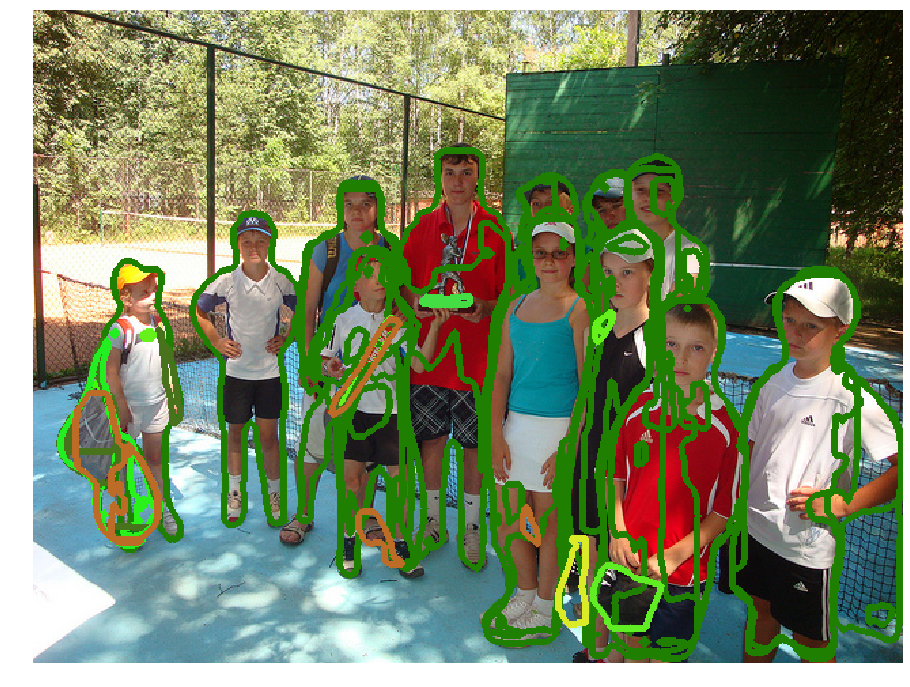

In [66]:
imshow(coco_demo.overlay_mask(img, pred))

In [40]:
from predict.predict_instance import *

In [43]:
test  = PredictSemantic(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7)

In [44]:
pred = test.compute_prediction(img)

In [67]:
test.predict(img)

(tensor([[515.9805, 189.8091, 639.3996, 474.0162],
         [267.1225,  95.6818, 349.2202, 407.1503],
         [191.2833, 119.0789, 269.4018, 393.0909],
         [335.1531, 149.6660, 406.7163, 459.3143],
         [117.5928, 145.6765, 193.6044, 377.4131],
         [217.7401, 164.0611, 281.3373, 408.3077],
         [396.3764, 193.1199, 526.3763, 473.1361],
         [379.8074, 152.5655, 464.2029, 452.4583],
         [297.4423, 106.9415, 380.9533, 456.7197],
         [233.2972, 136.9923, 306.6919, 413.8212],
         [187.4027, 147.3898, 228.6373, 381.0268],
         [199.4030, 108.3321, 396.8658, 419.2086],
         [422.1024, 104.8034, 509.1477, 347.2624],
         [318.8108, 139.0051, 526.3245, 452.2834],
         [ 39.8152, 180.5591, 108.7228, 395.5248],
         [195.2699, 117.9114, 268.0889, 265.8998],
         [426.4631, 107.0894, 502.7153, 243.3663],
         [400.1899, 127.0092, 471.7444, 342.9386],
         [403.8714, 119.6248, 455.7898, 255.3538],
         [407.8351, 119.9050, 4